## Experiment 4: TOVIMA Handcrafted NLP

Analyze the posts text computing the following NLP characteristics:
- Number of total tokens, entities, pos tags, stopwords, alphabetic tokens, digits and punctuation characters per post (spaCy module)
- Number of uppercases, special characters (e.g. symbols, emojis etc) per post
- Number of popular words (25 most common words among the 10% most popular posts) per post
- Sentiment and subjectivity of each post (TextBlob module)

Import modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load a greek spaCy model for nlp
import spacy
nlp = spacy.load("el_core_news_sm")

from textblob import TextBlob

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import metrics

Load and cleanup the data file

In [2]:
# Load the csv file containing the posts
# Use only "URL", "Link Text" and "Total Interactions" columns
posts_df = pd.read_csv("Datasets/tovima/tovima.csv",
                       usecols=["URL", "Link Text", "Total Interactions"]).head(522)[
    ["URL", "Link Text", "Total Interactions"]]

# Remove the " | Ειδήσεις - νέα - Το Βήμα Online" suffix from the "Link Text" column
posts_df["Link Text"] = posts_df["Link Text"].apply(
    lambda x: x[:-len(" | Ειδήσεις - νέα - Το Βήμα Online")] if x.endswith(" | Ειδήσεις - νέα - Το Βήμα Online") else x)

# Drop rows with missing values values
posts_df = posts_df.dropna().reset_index(drop=True)

# Filter out rows with "Total Interactions" values below 0.05 quantile and above 0.95 quantile
posts_df = posts_df.loc[(posts_df["Total Interactions"] >= posts_df[
    "Total Interactions"].quantile(.05)) & (posts_df["Total Interactions"] <= posts_df[
    "Total Interactions"].quantile(.95))].reset_index(drop=True)
posts_df

,URL,Link Text,Total Interactions
0,https://www.facebook.com/184884834877395/posts...,Οσιαν Βουόνγκ: Ο 33χρονος ποιητής που μαγεύει ...,0
1,https://www.facebook.com/184884834877395/posts...,Πώς ο ύπνος σχετίζεται με το έμφραγμα,0
2,https://www.facebook.com/184884834877395/posts...,Πόσο επικίνδυνη είναι η ινδική μετάλλαξη;,3
3,https://www.facebook.com/184884834877395/posts...,Μπουρλά: Ίσως εντός 2021 το χάπι για covid,3
4,https://www.facebook.com/184884834877395/posts...,Χριστίνα Χειλά Φαμέλη: Σοκάρει μιλώντας για τη...,0
...,...,...,...
491,https://www.facebook.com/184884834877395/posts...,Πού θα γίνονται δωρεάν rapid test την Τετάρτη,0
492,https://www.facebook.com/184884834877395/posts...,Γαλάζια σημαία:Ασημένια η Ελλάδα - Οι 545 ακτέ...,7
493,https://www.facebook.com/184884834877395/posts...,Χαλάει ο καιρός - Πού και πότε θα βρέξει,1
494,https://www.facebook.com/184884834877395/posts...,Ανησυχεί η «αθηναϊκή μετάλλαξη» – Τι λένε οι ε...,1


Number of total tokens, entities, pos tags, stopwords, alphabetic tokens, digits and punctuation characters per post (spaCy module)

In [3]:
# Adapted from https://github.com/conormm/blog/blob/master/_notebooks/structured-nlp.ipynb

def extract_tokens_meta_from_doc(doc:spacy.tokens.doc.Doc):
    """Extract tokens and metadata from individual spaCy doc."""
    return [
        (token.text, token.ent_type_, token.pos_, token.is_stop,
         token.is_alpha, token.is_digit, token.is_punct)
        for token in doc
    ]

def extract_tokens_meta_from_docs(docs):
    """Extract tokens and metadata from list of spaCy docs."""
    cols = [
        "doc_id", "token", "ent_type", "pos", "is_stop",
        "is_alpha", "is_digit", "is_punct"
    ]

    meta_df = []
    for idx, doc in enumerate(docs):
        meta = extract_tokens_meta_from_doc(doc)
        meta = pd.DataFrame(meta, columns=cols[1:])
        meta = meta.assign(doc_id = idx).loc[:, cols]
        meta_df.append(meta)

    return pd.concat(meta_df, ignore_index=True)

def aggregate_meta_per_doc(tokens_df):
    """Aggregates (summing) a 'tokens_df' dataframe per doc into another dataframe."""
    groups = pd.get_dummies(
        tokens_df, columns=["ent_type", "pos"]).groupby("doc_id")
    return groups.size().to_frame(name='n_tokens').merge(
        groups.sum(), left_index=True, right_index=True, how='inner').reset_index(drop=True)

docs = list(nlp.pipe(posts_df["Link Text"]))
tokens_df = extract_tokens_meta_from_docs(docs)
handnlp_df = aggregate_meta_per_doc(tokens_df)
handnlp_df

,n_tokens,is_stop,is_alpha,is_digit,is_punct,ent_type_,ent_type_GPE,ent_type_ORG,ent_type_PERSON,pos_ADJ,...,pos_NOUN,pos_NUM,pos_PART,pos_PRON,pos_PROPN,pos_PUNCT,pos_SCONJ,pos_SPACE,pos_VERB,pos_X
0,10,3,8,0,1,8,1,0,1,0,...,3,0,0,1,0,1,0,0,1,2
1,7,4,7,0,0,7,0,0,0,0,...,2,0,0,0,0,0,0,0,2,0
2,7,2,6,0,1,7,0,0,0,2,...,1,0,0,0,0,1,0,0,0,0
3,9,4,7,1,1,8,0,0,1,0,...,2,1,0,0,1,1,0,0,0,0
4,18,7,16,1,1,16,0,0,2,1,...,3,1,0,1,2,1,0,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,8,3,8,0,0,8,0,0,0,0,...,2,0,0,0,1,0,0,0,2,0
492,12,3,9,1,2,11,1,0,0,0,...,2,1,0,1,1,2,0,0,2,1
493,9,5,8,0,1,9,0,0,0,0,...,1,0,0,0,1,1,0,0,1,1
494,11,3,8,0,3,11,0,0,0,2,...,1,0,0,1,0,3,0,0,2,0


Number of uppercases, special characters (e.g. symbols, emojis etc) per post

In [4]:
# Merge the aggregated spaCy characteristics with the original posts dataframe
handnlp_df = posts_df.merge(handnlp_df, left_index=True, right_index=True, how='inner')

# Create a new column storing the number of uppercase characters in each post
handnlp_df["n_uppercase"] = handnlp_df["Link Text"].apply(lambda x: sum(c.isupper() for c in x))

# Create a new column storing the number of special tokens (e.g. symbols, emojis) in each post
handnlp_df["is_special"] = handnlp_df.apply(
    lambda x: x['n_tokens'] - x['is_alpha'] - x['is_digit'] - x['is_punct'], axis=1)
handnlp_df

,URL,Link Text,Total Interactions,n_tokens,is_stop,is_alpha,is_digit,is_punct,ent_type_,ent_type_GPE,...,pos_PART,pos_PRON,pos_PROPN,pos_PUNCT,pos_SCONJ,pos_SPACE,pos_VERB,pos_X,n_uppercase,is_special
0,https://www.facebook.com/184884834877395/posts...,Οσιαν Βουόνγκ: Ο 33χρονος ποιητής που μαγεύει ...,0,10,3,8,0,1,8,1,...,0,1,0,1,0,0,1,2,6,1
1,https://www.facebook.com/184884834877395/posts...,Πώς ο ύπνος σχετίζεται με το έμφραγμα,0,7,4,7,0,0,7,0,...,0,0,0,0,0,0,2,0,1,0
2,https://www.facebook.com/184884834877395/posts...,Πόσο επικίνδυνη είναι η ινδική μετάλλαξη;,3,7,2,6,0,1,7,0,...,0,0,0,1,0,0,0,0,1,0
3,https://www.facebook.com/184884834877395/posts...,Μπουρλά: Ίσως εντός 2021 το χάπι για covid,3,9,4,7,1,1,8,0,...,0,0,1,1,0,0,0,0,2,0
4,https://www.facebook.com/184884834877395/posts...,Χριστίνα Χειλά Φαμέλη: Σοκάρει μιλώντας για τη...,0,18,7,16,1,1,16,0,...,0,1,2,1,0,0,2,1,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,https://www.facebook.com/184884834877395/posts...,Πού θα γίνονται δωρεάν rapid test την Τετάρτη,0,8,3,8,0,0,8,0,...,0,0,1,0,0,0,2,0,2,0
492,https://www.facebook.com/184884834877395/posts...,Γαλάζια σημαία:Ασημένια η Ελλάδα - Οι 545 ακτέ...,7,12,3,9,1,2,11,1,...,0,1,1,2,0,0,2,1,4,0
493,https://www.facebook.com/184884834877395/posts...,Χαλάει ο καιρός - Πού και πότε θα βρέξει,1,9,5,8,0,1,9,0,...,0,0,1,1,0,0,1,1,2,0
494,https://www.facebook.com/184884834877395/posts...,Ανησυχεί η «αθηναϊκή μετάλλαξη» – Τι λένε οι ε...,1,11,3,8,0,3,11,0,...,0,1,0,3,0,0,2,0,2,0


Number of popular words (25 most common words among the 10% most popular posts) per post

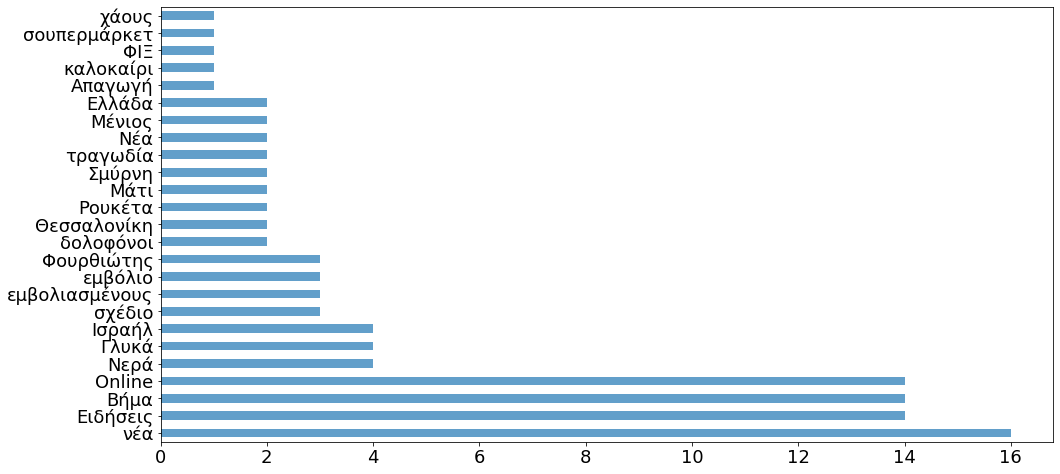

In [5]:
# Find the 10% most popular posts
top10_posts_df = handnlp_df.loc[handnlp_df["Total Interactions"] >= handnlp_df[
    "Total Interactions"].quantile(.9)].reset_index(drop=True)
# Get their tokens analysis by spaCy
top10_tokens_df = extract_tokens_meta_from_docs(list(nlp.pipe(top10_posts_df["Link Text"])))

# Plot the popular words
top10_tokens_df.query("is_alpha == True & is_stop == False").token.value_counts().head(25).plot(kind="barh", figsize=(16, 8), alpha=.7)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.show()

In [6]:
# Get the popular words
top10_words = list(top10_tokens_df.query(
    "is_alpha == True & is_stop == False").token.value_counts().head(25).index)

# Create a new column storing the number of popular words in each post
handnlp_df["n_popular_tokens"] = handnlp_df["Link Text"].apply(lambda x: sum(token in top10_words for token in x.split()))
handnlp_df

,URL,Link Text,Total Interactions,n_tokens,is_stop,is_alpha,is_digit,is_punct,ent_type_,ent_type_GPE,...,pos_PRON,pos_PROPN,pos_PUNCT,pos_SCONJ,pos_SPACE,pos_VERB,pos_X,n_uppercase,is_special,n_popular_tokens
0,https://www.facebook.com/184884834877395/posts...,Οσιαν Βουόνγκ: Ο 33χρονος ποιητής που μαγεύει ...,0,10,3,8,0,1,8,1,...,1,0,1,0,0,1,2,6,1,0
1,https://www.facebook.com/184884834877395/posts...,Πώς ο ύπνος σχετίζεται με το έμφραγμα,0,7,4,7,0,0,7,0,...,0,0,0,0,0,2,0,1,0,0
2,https://www.facebook.com/184884834877395/posts...,Πόσο επικίνδυνη είναι η ινδική μετάλλαξη;,3,7,2,6,0,1,7,0,...,0,0,1,0,0,0,0,1,0,0
3,https://www.facebook.com/184884834877395/posts...,Μπουρλά: Ίσως εντός 2021 το χάπι για covid,3,9,4,7,1,1,8,0,...,0,1,1,0,0,0,0,2,0,0
4,https://www.facebook.com/184884834877395/posts...,Χριστίνα Χειλά Φαμέλη: Σοκάρει μιλώντας για τη...,0,18,7,16,1,1,16,0,...,1,2,1,0,0,2,1,5,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,https://www.facebook.com/184884834877395/posts...,Πού θα γίνονται δωρεάν rapid test την Τετάρτη,0,8,3,8,0,0,8,0,...,0,1,0,0,0,2,0,2,0,0
492,https://www.facebook.com/184884834877395/posts...,Γαλάζια σημαία:Ασημένια η Ελλάδα - Οι 545 ακτέ...,7,12,3,9,1,2,11,1,...,1,1,2,0,0,2,1,4,0,1
493,https://www.facebook.com/184884834877395/posts...,Χαλάει ο καιρός - Πού και πότε θα βρέξει,1,9,5,8,0,1,9,0,...,0,1,1,0,0,1,1,2,0,0
494,https://www.facebook.com/184884834877395/posts...,Ανησυχεί η «αθηναϊκή μετάλλαξη» – Τι λένε οι ε...,1,11,3,8,0,3,11,0,...,1,0,3,0,0,2,0,2,0,0


Sentiment and subjectivity of each post (TextBlob module)

In [7]:
# Adapted from https://github.com/dimitrakatseli/review_sentiment_analysis

def get_polarity(text):
    textblob = TextBlob(text)
    textblob_en = textblob.translate(from_lang="el", to='en')
    return textblob_en.sentiment.polarity

def get_subjectivity(text):
    textblob = TextBlob(text)
    textblob_en = textblob.translate(from_lang="el", to='en')
    return textblob_en.sentiment.subjectivity

# Create a new column storing the polarity of each post
handnlp_df["polarity"] = handnlp_df["Link Text"].apply(lambda x: get_polarity(x))

# Create a new column storing the subjectivity of each post
handnlp_df["subjectivity"] = handnlp_df["Link Text"].apply(lambda x: get_subjectivity(x))

# Print the final dataframe containing all handcrafted NLP characteristics
handnlp_df

,URL,Link Text,Total Interactions,n_tokens,is_stop,is_alpha,is_digit,is_punct,ent_type_,ent_type_GPE,...,pos_PUNCT,pos_SCONJ,pos_SPACE,pos_VERB,pos_X,n_uppercase,is_special,n_popular_tokens,polarity,subjectivity
0,https://www.facebook.com/184884834877395/posts...,Οσιαν Βουόνγκ: Ο 33χρονος ποιητής που μαγεύει ...,0,10,3,8,0,1,8,1,...,1,0,0,1,2,6,1,0,0.100000,0.200000
1,https://www.facebook.com/184884834877395/posts...,Πώς ο ύπνος σχετίζεται με το έμφραγμα,0,7,4,7,0,0,7,0,...,0,0,0,2,0,1,0,0,0.000000,0.400000
2,https://www.facebook.com/184884834877395/posts...,Πόσο επικίνδυνη είναι η ινδική μετάλλαξη;,3,7,2,6,0,1,7,0,...,1,0,0,0,0,1,0,0,-0.600000,0.900000
3,https://www.facebook.com/184884834877395/posts...,Μπουρλά: Ίσως εντός 2021 το χάπι για covid,3,9,4,7,1,1,8,0,...,1,0,0,0,0,2,0,0,0.000000,0.000000
4,https://www.facebook.com/184884834877395/posts...,Χριστίνα Χειλά Φαμέλη: Σοκάρει μιλώντας για τη...,0,18,7,16,1,1,16,0,...,1,0,0,2,1,5,0,1,-1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,https://www.facebook.com/184884834877395/posts...,Πού θα γίνονται δωρεάν rapid test την Τετάρτη,0,8,3,8,0,0,8,0,...,0,0,0,2,0,2,0,0,0.400000,0.800000
492,https://www.facebook.com/184884834877395/posts...,Γαλάζια σημαία:Ασημένια η Ελλάδα - Οι 545 ακτέ...,7,12,3,9,1,2,11,1,...,2,0,0,2,1,4,0,1,0.000000,0.100000
493,https://www.facebook.com/184884834877395/posts...,Χαλάει ο καιρός - Πού και πότε θα βρέξει,1,9,5,8,0,1,9,0,...,1,0,0,1,1,2,0,0,0.000000,0.000000
494,https://www.facebook.com/184884834877395/posts...,Ανησυχεί η «αθηναϊκή μετάλλαξη» – Τι λένε οι ε...,1,11,3,8,0,3,11,0,...,3,0,0,2,0,2,0,0,0.000000,0.000000


Plot some characteristics across posts

In [8]:
# Print most frequent entity types among posts
# Check also https://spacy.io/usage/linguistic-features#named-entities-101
# ORG: Companies, agencies, institutions, GPE: Geopolitical entity, i.e. countries, cities, states
tokens_df.query("ent_type != ''").ent_type.value_counts()

GPE       113
PERSON     86
ORG        65
Name: ent_type, dtype: int64

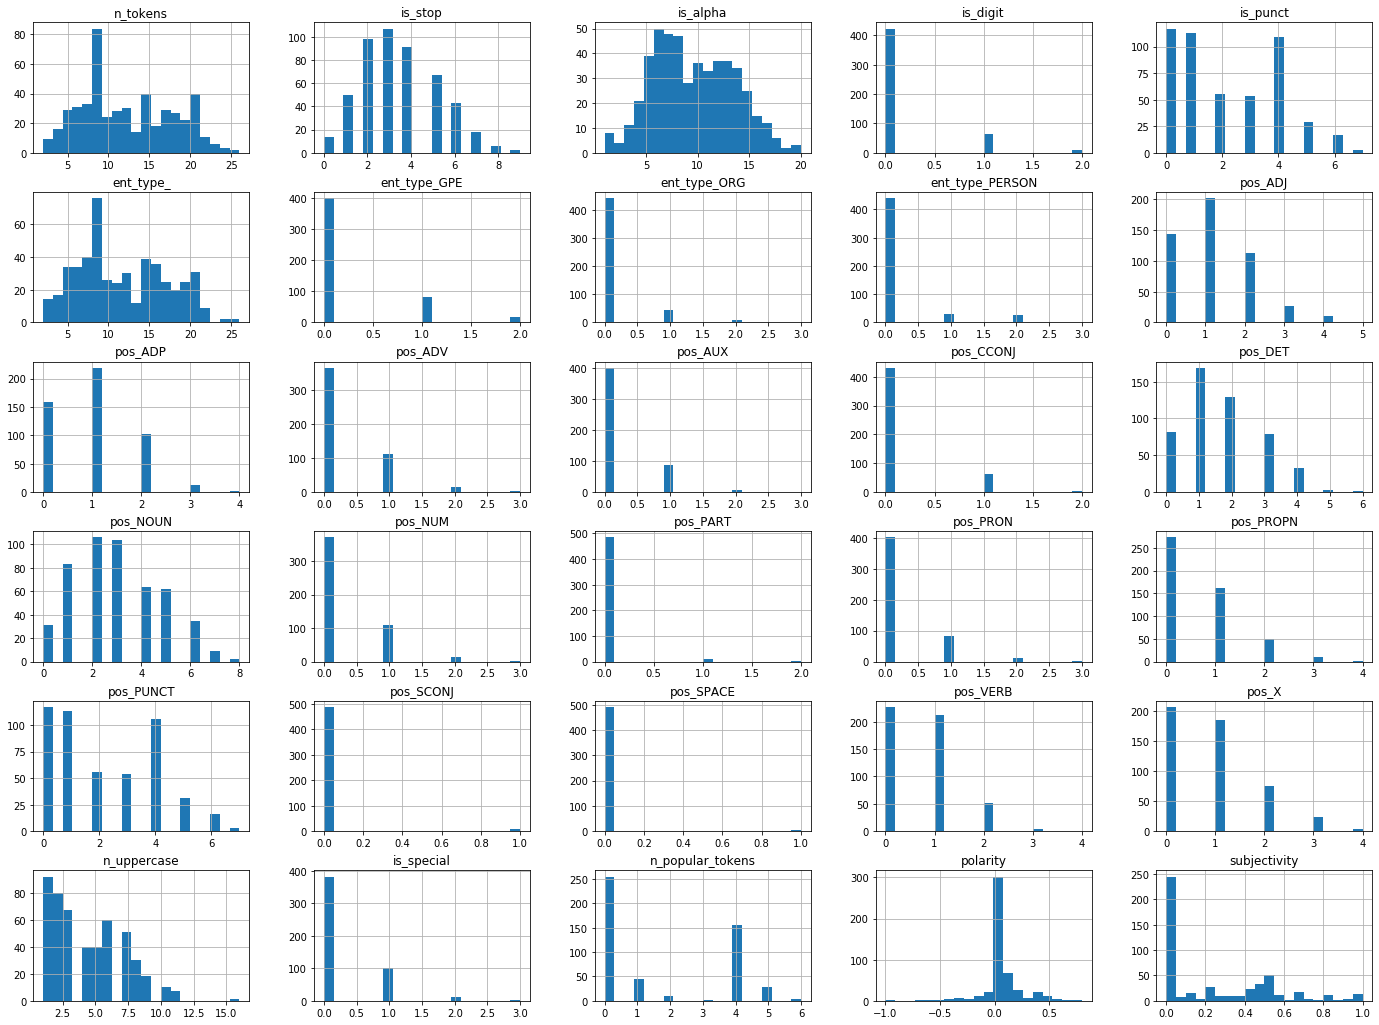

In [9]:
# Plot histograms for each extracted nlp characteristic
handnlp_df.iloc[:, 3:].hist(figsize=(24, 18), bins=20)
plt.show()

Split dataset to train and test subsets

In [10]:
train_df, test_df = train_test_split(
    handnlp_df, test_size=0.25, random_state=42)

Regression problem

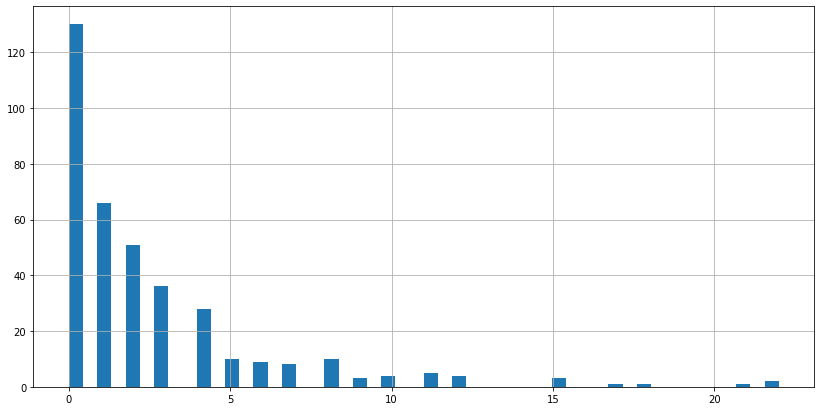

In [11]:
train_x = train_df.iloc[:, 3:]
train_y = train_df["Total Interactions"]

test_x = test_df.iloc[:, 3:]
test_y = test_df["Total Interactions"]

# Plot how the column we will be predicting looks like
train_df["Total Interactions"].hist(figsize=(14, 7), bins=50)
plt.show()

In [12]:
# Train and test the LinearRegression model
lin_reg = LinearRegression().fit(train_x, train_y)
pred_y = lin_reg.predict(test_x)

print('r2_score:', metrics.r2_score(test_y, pred_y))
print('MAE:', metrics.mean_absolute_error(test_y, pred_y))
print('MSE:', metrics.mean_squared_error(test_y, pred_y))

r2_score: -0.039352161202421465
MAE: 2.89534319333576
MSE: 17.307957871230567


In [13]:
# Train and test the KNeighborsRegressor model
kn_reg = KNeighborsRegressor().fit(train_x, train_y)
pred_y = kn_reg.predict(test_x)

print('r2_score:', metrics.r2_score(test_y, pred_y))
print('MAE:', metrics.mean_absolute_error(test_y, pred_y))
print('MSE:', metrics.mean_squared_error(test_y, pred_y))

r2_score: -0.10188860812884948
MAE: 2.914516129032257
MSE: 18.34935483870968


In [14]:
# Train and test the RandomForestRegressor model
rf_reg = RandomForestRegressor(n_estimators=200).fit(train_x, train_y)
pred_y = rf_reg.predict(test_x)

print('r2_score:', metrics.r2_score(test_y, pred_y))
print('MAE:', metrics.mean_absolute_error(test_y, pred_y))
print('MSE:', metrics.mean_squared_error(test_y, pred_y))

r2_score: -0.058594013774829534
MAE: 2.9514503488223247
MSE: 17.628385524262413


In [15]:
# Show features importances
important_features = pd.Series(data=rf_reg.feature_importances_, index=train_x.columns)
important_features.sort_values(ascending=False, inplace=True)
important_features.astype(float)

polarity            0.081021
n_popular_tokens    0.070065
subjectivity        0.064732
n_uppercase         0.062519
pos_DET             0.061477
pos_NOUN            0.056610
pos_ADP             0.047138
ent_type_           0.046697
is_alpha            0.041152
pos_PROPN           0.040481
ent_type_GPE        0.039867
n_tokens            0.039710
pos_ADJ             0.036031
is_stop             0.035223
pos_PUNCT           0.030968
pos_X               0.030844
pos_VERB            0.030437
pos_ADV             0.027822
is_punct            0.027470
ent_type_PERSON     0.023052
is_special          0.020343
pos_NUM             0.017642
pos_SCONJ           0.016598
pos_PRON            0.015363
pos_PART            0.011488
pos_AUX             0.009783
is_digit            0.006471
pos_CCONJ           0.005676
ent_type_ORG        0.002868
pos_SPACE           0.000450
dtype: float64

Classification problem

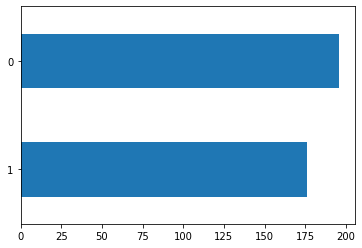

In [16]:
# For classification, we consider 2 categories:
#   -Class 0: posts with "Total Interactions" below the column's median
#   -Class 1: posts with "Total Interactions" above the column's median

median = train_df["Total Interactions"].median()

train_x = train_df.iloc[:, 3:]
train_y = train_df["Total Interactions"].apply(lambda x: int(x > median))

test_x = test_df.iloc[:, 3:]
test_y = test_df["Total Interactions"].apply(lambda x: int(x > median))

# Plot how the column we will be predicting looks like
train_df["Total Interactions"].apply(
    lambda x: int(x > median)).value_counts().sort_values().plot(kind = 'barh')
plt.show()

In [19]:
# Train and test the LogisticRegression model
lr_clf = LogisticRegression(solver='lbfgs', max_iter=2500).fit(train_x, train_y)
pred_y = lr_clf.predict(test_x)

print('accuracy:', metrics.accuracy_score(test_y, pred_y))
print('classification_report:\n', metrics.classification_report(test_y, pred_y))

accuracy: 0.49193548387096775
classification_report:
               precision    recall  f1-score   support

           0       0.49      0.55      0.52        62
           1       0.49      0.44      0.46        62

    accuracy                           0.49       124
   macro avg       0.49      0.49      0.49       124
weighted avg       0.49      0.49      0.49       124



In [20]:
# Train and test the KNeighborsClassifier model
kn_clf = KNeighborsClassifier().fit(train_x, train_y)
pred_y = kn_clf.predict(test_x)

print('accuracy:', metrics.accuracy_score(test_y, pred_y))
print('classification_report:\n', metrics.classification_report(test_y, pred_y))

accuracy: 0.4838709677419355
classification_report:
               precision    recall  f1-score   support

           0       0.49      0.56      0.52        62
           1       0.48      0.40      0.44        62

    accuracy                           0.48       124
   macro avg       0.48      0.48      0.48       124
weighted avg       0.48      0.48      0.48       124



In [21]:
# Train and test the RandomForestClassifier model
rf_clf = RandomForestClassifier(n_estimators=200).fit(train_x, train_y)
pred_y = rf_clf.predict(test_x)

print('accuracy:', metrics.accuracy_score(test_y, pred_y))
print('classification_report:\n', metrics.classification_report(test_y, pred_y))

accuracy: 0.47580645161290325
classification_report:
               precision    recall  f1-score   support

           0       0.48      0.55      0.51        62
           1       0.47      0.40      0.43        62

    accuracy                           0.48       124
   macro avg       0.48      0.48      0.47       124
weighted avg       0.48      0.48      0.47       124



In [22]:
# Show features importances
important_features = pd.Series(data=rf_clf.feature_importances_, index=train_x.columns)
important_features.sort_values(ascending=False, inplace=True)
important_features.astype(float)

n_tokens            0.066648
subjectivity        0.065003
ent_type_           0.063060
is_alpha            0.061646
pos_NOUN            0.060342
n_uppercase         0.057578
is_stop             0.054598
polarity            0.053141
pos_DET             0.044165
pos_PROPN           0.038691
pos_ADJ             0.038243
pos_ADP             0.037731
pos_PUNCT           0.036932
is_punct            0.033384
pos_X               0.031428
pos_VERB            0.030729
n_popular_tokens    0.025808
pos_ADV             0.024269
ent_type_GPE        0.023988
pos_PRON            0.022919
pos_NUM             0.022909
is_special          0.019045
pos_AUX             0.018496
pos_CCONJ           0.015591
ent_type_PERSON     0.015485
ent_type_ORG        0.013577
is_digit            0.013308
pos_PART            0.005222
pos_SCONJ           0.004292
pos_SPACE           0.001774
dtype: float64